# 🤖 Modelado y Evaluación de Modelos
## Proyecto Final - MLOps con CRISP-DM

**Fase 4: Modelado con MLflow**  
**Fase 5: Evaluación**

Este notebook contiene:
- Entrenamiento de 4 modelos diferentes (Logistic Regression, Random Forest, XGBoost, LightGBM)
- Hyperparameter tuning para cada modelo
- Comparación sistemática de modelos
- Evaluación completa con métricas y visualizaciones
- Registro de modelos en MLflow


## 1. Importación de Librerías


In [7]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Agregar src al path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
from mlflow.tracking import MlflowClient

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, confusion_matrix,
    roc_curve, precision_recall_curve, classification_report
)

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("✅ Librerías importadas correctamente")


✅ Librerías importadas correctamente


## 2. Configuración de MLflow


In [8]:
# Configurar MLflow
MLFLOW_TRACKING_URI = "http://localhost:5000"
EXPERIMENT_NAME = "churn-prediction-experiment"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"✅ MLflow configurado")
print(f"📊 Tracking URI: {MLFLOW_TRACKING_URI}")
print(f"📊 Experimento: {EXPERIMENT_NAME}")
print(f"🌐 UI disponible en: {MLFLOW_TRACKING_URI}")

# Verificar conexión
try:
    client = MlflowClient()
    experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
    print(f"✅ Experimento encontrado: {experiment.experiment_id}")
except Exception as e:
    print(f"⚠️ No se pudo conectar a MLflow: {e}")
    print("   Asegúrate de tener MLflow server corriendo en http://localhost:5000")


✅ MLflow configurado
📊 Tracking URI: http://localhost:5000
📊 Experimento: churn-prediction-experiment
🌐 UI disponible en: http://localhost:5000
✅ Experimento encontrado: 0


## 3. Preparación de Datos


In [9]:
from src.data.data_preparation import prepare_data

# Preparar datos
print("📊 Preparando datos...")
data_dict = prepare_data()

X_train = data_dict["X_train"]
y_train = data_dict["y_train"]
X_val = data_dict["X_val"]
y_val = data_dict["y_val"]
X_test = data_dict["X_test"]
y_test = data_dict["y_test"]

print(f"\n✅ Datos preparados:")
print(f"   Train: {X_train.shape}")
print(f"   Val:   {X_val.shape}")
print(f"   Test:  {X_test.shape}")


📊 Preparando datos...
✅ Datos cargados: 30,000 filas × 24 columnas

📌 División temporal:
  Train: 14,863 registros
  Val:   7,665 registros
  Test:  7,472 registros

✅ Preparación completa
  Train procesado: (14863, 2239)
  Val procesado:   (7665, 2239)
  Test procesado:  (7472, 2239)

✅ Datos preparados:
   Train: (14863, 2239)
   Val:   (7665, 2239)
   Test:  (7472, 2239)


## 4. Entrenamiento de Modelos

### 4.1 Logistic Regression


In [10]:
print("="*60)
print("🔵 Entrenando Logistic Regression...")
print("="*60)

# Espacio de hiperparámetros
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000]
}

# Modelo base
base_model_lr = LogisticRegression(random_state=42)

# Randomized Search
random_search_lr = RandomizedSearchCV(
    base_model_lr, param_grid_lr, 
    n_iter=20, cv=3, scoring='roc_auc',
    n_jobs=-1, random_state=42, verbose=1
)

random_search_lr.fit(X_train, y_train)

best_model_lr = random_search_lr.best_estimator_
best_params_lr = random_search_lr.best_params_

# Predicciones
y_pred_lr = best_model_lr.predict(X_val)
y_pred_proba_lr = best_model_lr.predict_proba(X_val)[:, 1]

# Métricas
metrics_lr = {
    'accuracy': accuracy_score(y_val, y_pred_lr),
    'precision': precision_score(y_val, y_pred_lr),
    'recall': recall_score(y_val, y_pred_lr),
    'f1_score': f1_score(y_val, y_pred_lr),
    'roc_auc': roc_auc_score(y_val, y_pred_proba_lr),
    'log_loss': log_loss(y_val, y_pred_proba_lr)
}

# Logging en MLflow
with mlflow.start_run(run_name="LogisticRegression"):
    mlflow.log_params(best_params_lr)
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metrics(metrics_lr)
    mlflow.sklearn.log_model(best_model_lr, "model")
    mlflow.log_param("n_features", X_train.shape[1])

print(f"\n✅ Mejores parámetros: {best_params_lr}")
print(f"📊 Métricas:")
for metric, value in metrics_lr.items():
    print(f"   {metric:15s}: {value:.4f}")


🔵 Entrenando Logistic Regression...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


2025/11/14 11:02:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/14 11:03:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/0/runs/3bc20586d686457cbfdfd0fa7d0d2f92
🧪 View experiment at: http://localhost:5000/#/experiments/0

✅ Mejores parámetros: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1000, 'C': 0.1}
📊 Métricas:
   accuracy       : 0.8219
   precision      : 0.8159
   recall         : 0.8277
   f1_score       : 0.8217
   roc_auc        : 0.8757
   log_loss       : 0.4603


### 4.2 Random Forest


In [11]:
print("="*60)
print("🟢 Entrenando Random Forest...")
print("="*60)

# Espacio de hiperparámetros
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Modelo base
base_model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized Search
random_search_rf = RandomizedSearchCV(
    base_model_rf, param_grid_rf,
    n_iter=30, cv=3, scoring='roc_auc',
    n_jobs=-1, random_state=42, verbose=1
)

random_search_rf.fit(X_train, y_train)

best_model_rf = random_search_rf.best_estimator_
best_params_rf = random_search_rf.best_params_

# Predicciones
y_pred_rf = best_model_rf.predict(X_val)
y_pred_proba_rf = best_model_rf.predict_proba(X_val)[:, 1]

# Métricas
metrics_rf = {
    'accuracy': accuracy_score(y_val, y_pred_rf),
    'precision': precision_score(y_val, y_pred_rf),
    'recall': recall_score(y_val, y_pred_rf),
    'f1_score': f1_score(y_val, y_pred_rf),
    'roc_auc': roc_auc_score(y_val, y_pred_proba_rf),
    'log_loss': log_loss(y_val, y_pred_proba_rf)
}

# Logging en MLflow
with mlflow.start_run(run_name="RandomForest"):
    mlflow.log_params(best_params_rf)
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_metrics(metrics_rf)
    mlflow.sklearn.log_model(best_model_rf, "model")
    mlflow.log_param("n_features", X_train.shape[1])

print(f"\n✅ Mejores parámetros: {best_params_rf}")
print(f"📊 Métricas:")
for metric, value in metrics_rf.items():
    print(f"   {metric:15s}: {value:.4f}")


🟢 Entrenando Random Forest...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


2025/11/14 12:01:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/14 12:01:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest at: http://localhost:5000/#/experiments/0/runs/b2c4e3c5a66341d79b70a5afc1048126
🧪 View experiment at: http://localhost:5000/#/experiments/0

✅ Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
📊 Métricas:
   accuracy       : 0.8492
   precision      : 0.8467
   recall         : 0.8498
   f1_score       : 0.8482
   roc_auc        : 0.8825
   log_loss       : 0.4182


### 4.3 XGBoost


In [12]:
print("="*60)
print("🟡 Entrenando XGBoost...")
print("="*60)

# Espacio de hiperparámetros
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Modelo base
base_model_xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# Randomized Search
random_search_xgb = RandomizedSearchCV(
    base_model_xgb, param_grid_xgb,
    n_iter=30, cv=3, scoring='roc_auc',
    n_jobs=-1, random_state=42, verbose=1
)

random_search_xgb.fit(X_train, y_train)

best_model_xgb = random_search_xgb.best_estimator_
best_params_xgb = random_search_xgb.best_params_

# Predicciones
y_pred_xgb = best_model_xgb.predict(X_val)
y_pred_proba_xgb = best_model_xgb.predict_proba(X_val)[:, 1]

# Métricas
metrics_xgb = {
    'accuracy': accuracy_score(y_val, y_pred_xgb),
    'precision': precision_score(y_val, y_pred_xgb),
    'recall': recall_score(y_val, y_pred_xgb),
    'f1_score': f1_score(y_val, y_pred_xgb),
    'roc_auc': roc_auc_score(y_val, y_pred_proba_xgb),
    'log_loss': log_loss(y_val, y_pred_proba_xgb)
}

# Logging en MLflow
with mlflow.start_run(run_name="XGBoost"):
    mlflow.log_params(best_params_xgb)
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_metrics(metrics_xgb)
    mlflow.xgboost.log_model(best_model_xgb, "model")
    mlflow.log_param("n_features", X_train.shape[1])

print(f"\n✅ Mejores parámetros: {best_params_xgb}")
print(f"📊 Métricas:")
for metric, value in metrics_xgb.items():
    print(f"   {metric:15s}: {value:.4f}")


🟡 Entrenando XGBoost...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


2025/11/14 12:06:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/14 12:06:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/0/runs/7705c5be79e94bf5bf0ed8cd060d63e3
🧪 View experiment at: http://localhost:5000/#/experiments/0

✅ Mejores parámetros: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
📊 Métricas:
   accuracy       : 0.8601
   precision      : 0.8609
   recall         : 0.8564
   f1_score       : 0.8586
   roc_auc        : 0.8879
   log_loss       : 0.4366


### 4.4 LightGBM


In [13]:
print("="*60)
print("🟣 Entrenando LightGBM...")
print("="*60)

# Espacio de hiperparámetros
param_grid_lgb = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, -1],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'num_leaves': [31, 50, 100, 200],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Modelo base
base_model_lgb = LGBMClassifier(random_state=42, verbose=-1)

# Randomized Search
random_search_lgb = RandomizedSearchCV(
    base_model_lgb, param_grid_lgb,
    n_iter=30, cv=3, scoring='roc_auc',
    n_jobs=-1, random_state=42, verbose=1
)

random_search_lgb.fit(X_train, y_train)

best_model_lgb = random_search_lgb.best_estimator_
best_params_lgb = random_search_lgb.best_params_

# Predicciones
y_pred_lgb = best_model_lgb.predict(X_val)
y_pred_proba_lgb = best_model_lgb.predict_proba(X_val)[:, 1]

# Métricas
metrics_lgb = {
    'accuracy': accuracy_score(y_val, y_pred_lgb),
    'precision': precision_score(y_val, y_pred_lgb),
    'recall': recall_score(y_val, y_pred_lgb),
    'f1_score': f1_score(y_val, y_pred_lgb),
    'roc_auc': roc_auc_score(y_val, y_pred_proba_lgb),
    'log_loss': log_loss(y_val, y_pred_proba_lgb)
}

# Logging en MLflow
with mlflow.start_run(run_name="LightGBM"):
    mlflow.log_params(best_params_lgb)
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_metrics(metrics_lgb)
    mlflow.lightgbm.log_model(best_model_lgb, "model")
    mlflow.log_param("n_features", X_train.shape[1])

print(f"\n✅ Mejores parámetros: {best_params_lgb}")
print(f"📊 Métricas:")
for metric, value in metrics_lgb.items():
    print(f"   {metric:15s}: {value:.4f}")


🟣 Entrenando LightGBM...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


2025/11/14 12:07:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/14 12:07:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://localhost:5000/#/experiments/0/runs/199d8961a153465aad5e7e574ca084b2
🧪 View experiment at: http://localhost:5000/#/experiments/0

✅ Mejores parámetros: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 200, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
📊 Métricas:
   accuracy       : 0.8584
   precision      : 0.8587
   recall         : 0.8553
   f1_score       : 0.8570
   roc_auc        : 0.8868
   log_loss       : 0.4387


## 5. Comparación de Modelos


📊 COMPARACIÓN DE MODELOS (Validation Set)
                     accuracy  precision  recall  f1_score  roc_auc  log_loss
XGBoost                0.8601     0.8609  0.8564    0.8586   0.8879    0.4366
LightGBM               0.8584     0.8587  0.8553    0.8570   0.8868    0.4387
Random Forest          0.8492     0.8467  0.8498    0.8482   0.8825    0.4182
Logistic Regression    0.8219     0.8159  0.8277    0.8217   0.8757    0.4603


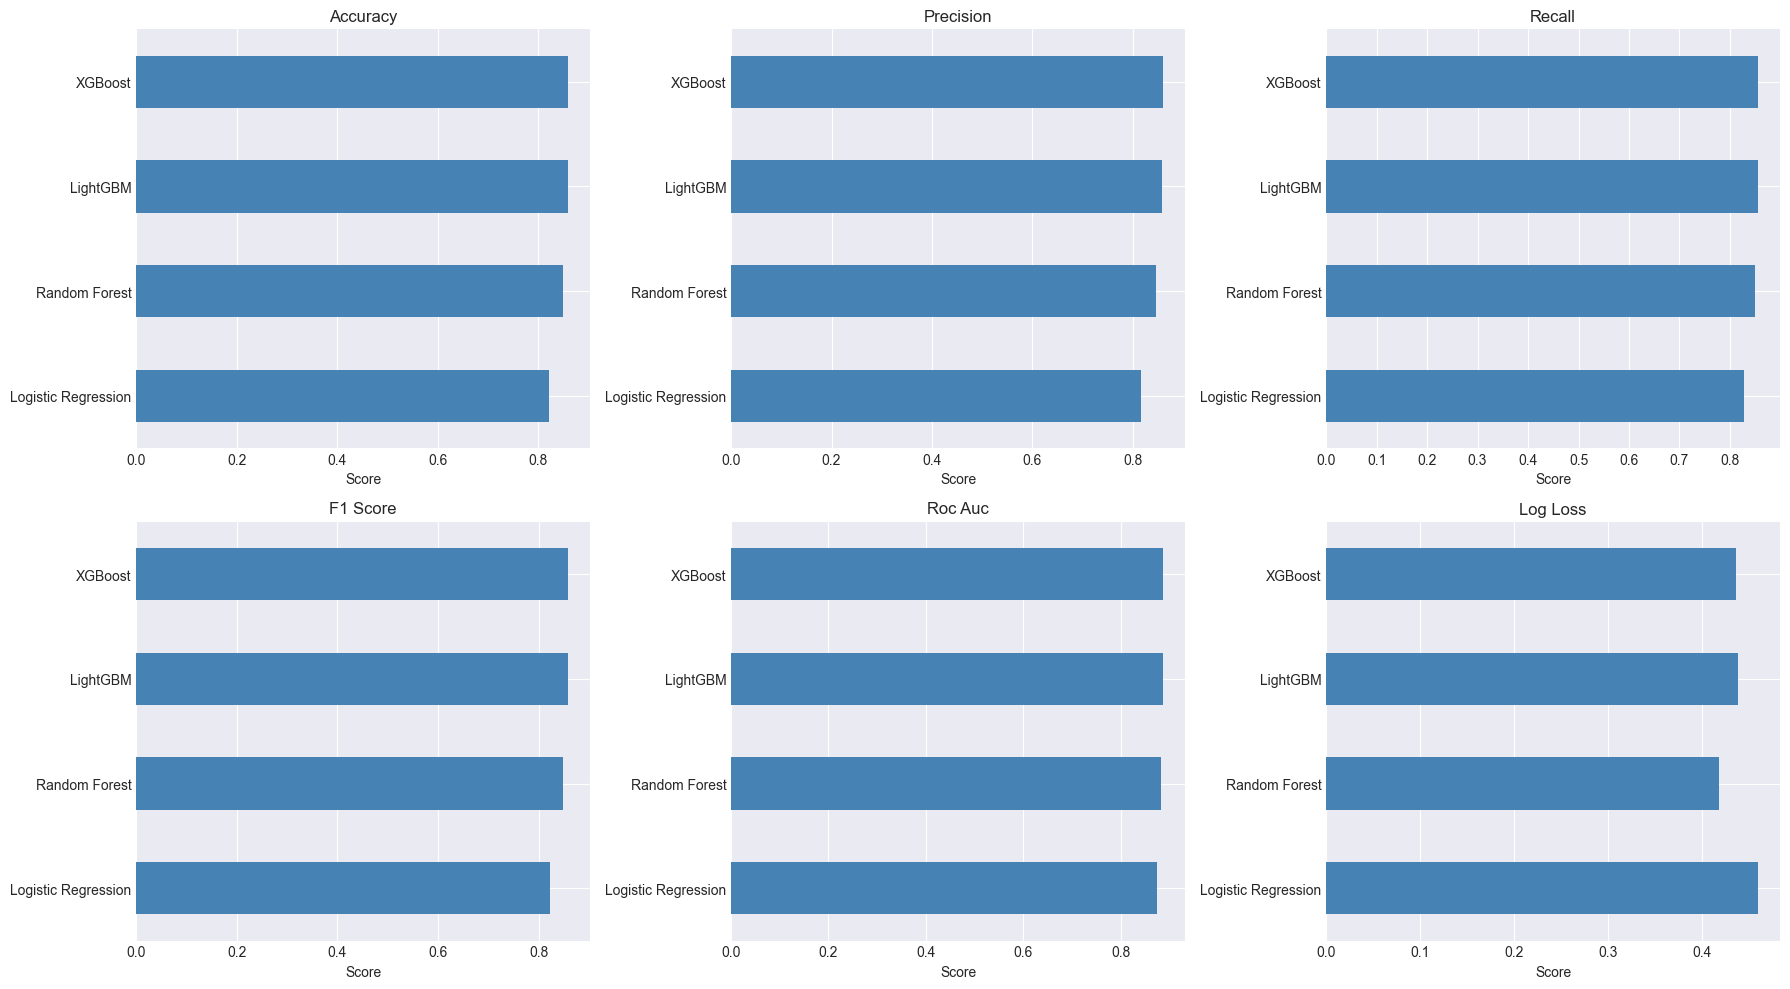


🏆 MEJOR MODELO: XGBoost
   ROC-AUC: 0.8879


In [14]:
# Crear DataFrame de comparación
comparison_data = {
    'Logistic Regression': metrics_lr,
    'Random Forest': metrics_rf,
    'XGBoost': metrics_xgb,
    'LightGBM': metrics_lgb
}

comparison_df = pd.DataFrame(comparison_data).T
comparison_df = comparison_df.sort_values('roc_auc', ascending=False)

print("="*70)
print("📊 COMPARACIÓN DE MODELOS (Validation Set)")
print("="*70)
print(comparison_df.round(4))

# Visualización
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'log_loss']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    comparison_df[metric].plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title(f'{metric.replace("_", " ").title()}')
    ax.set_xlabel('Score')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Identificar mejor modelo
best_model_name = comparison_df.index[0]
best_roc_auc = comparison_df.loc[best_model_name, 'roc_auc']

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   ROC-AUC: {best_roc_auc:.4f}")


## 6. Evaluación del Mejor Modelo en Test Set

Seleccionamos el mejor modelo y lo evaluamos en el conjunto de test.


In [15]:
# Seleccionar mejor modelo
models_dict = {
    'Logistic Regression': best_model_lr,
    'Random Forest': best_model_rf,
    'XGBoost': best_model_xgb,
    'LightGBM': best_model_lgb
}

best_model = models_dict[best_model_name]

# Predicciones en test
y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

# Métricas en test
metrics_test = {
    'accuracy': accuracy_score(y_test, y_pred_test),
    'precision': precision_score(y_test, y_pred_test),
    'recall': recall_score(y_test, y_pred_test),
    'f1_score': f1_score(y_test, y_pred_test),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_test),
    'log_loss': log_loss(y_test, y_pred_proba_test)
}

print("="*70)
print(f"📊 EVALUACIÓN DEL MEJOR MODELO ({best_model_name}) EN TEST SET")
print("="*70)
print("\nMétricas:")
for metric, value in metrics_test.items():
    print(f"   {metric:15s}: {value:.4f}")

print("\n" + "-"*70)
print("Classification Report:")
print("-"*70)
print(classification_report(y_test, y_pred_test, 
                            target_names=['No Abandono', 'Abandono']))


📊 EVALUACIÓN DEL MEJOR MODELO (XGBoost) EN TEST SET

Métricas:
   accuracy       : 0.8642
   precision      : 0.8720
   recall         : 0.8526
   f1_score       : 0.8622
   roc_auc        : 0.8959
   log_loss       : 0.4242

----------------------------------------------------------------------
Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

 No Abandono       0.86      0.88      0.87      3747
    Abandono       0.87      0.85      0.86      3725

    accuracy                           0.86      7472
   macro avg       0.86      0.86      0.86      7472
weighted avg       0.86      0.86      0.86      7472



## 7. Visualizaciones de Evaluación

### 7.1 Matriz de Confusión


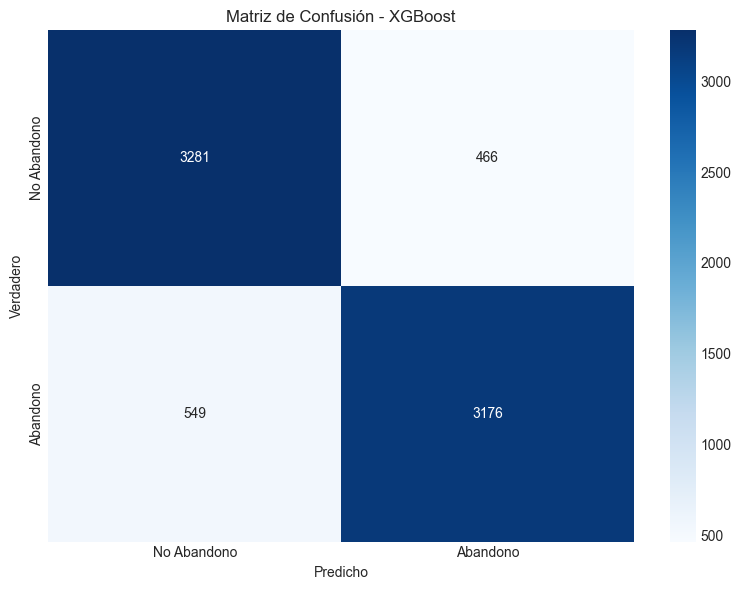

In [16]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Abandono', 'Abandono'],
            yticklabels=['No Abandono', 'Abandono'])
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()


### 7.2 Curva ROC


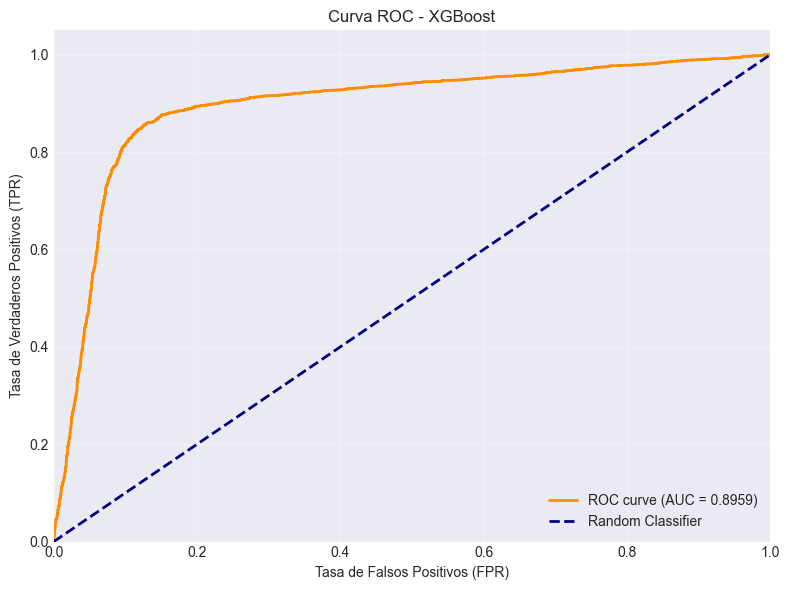

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
auc_score = roc_auc_score(y_test, y_pred_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title(f'Curva ROC - {best_model_name}')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 7.3 Curva Precision-Recall


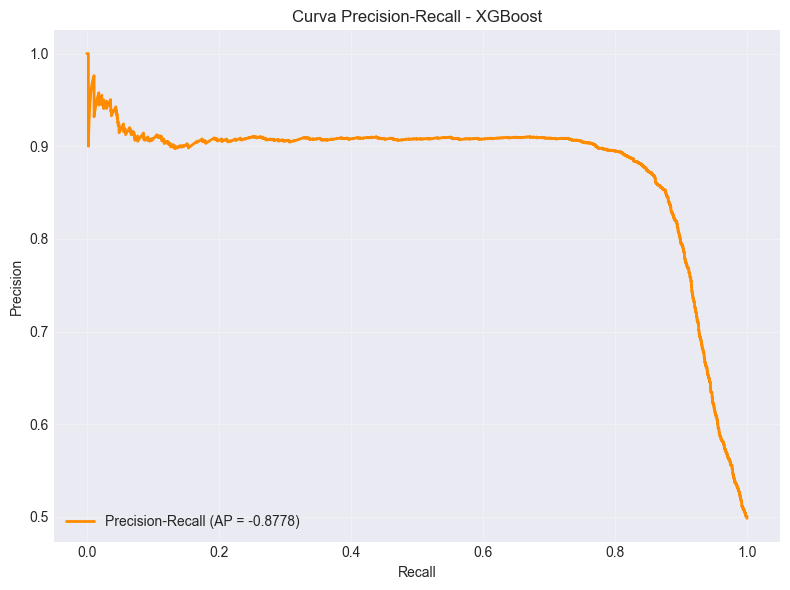

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
avg_precision = np.trapz(precision, recall)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2,
         label=f'Precision-Recall (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Curva Precision-Recall - {best_model_name}')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 7.4 Feature Importance (si está disponible)


In [19]:
# Intentar obtener feature importance
try:
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importances = np.abs(best_model.coef_[0])
    else:
        importances = None
    
    if importances is not None:
        # Obtener nombres de features (si están disponibles)
        feature_names = data_dict.get('feature_names', [f'Feature_{i}' for i in range(len(importances))])
        
        # Crear DataFrame
        feature_imp_df = pd.DataFrame({
            'feature': feature_names[:len(importances)],
            'importance': importances
        }).sort_values('importance', ascending=False).head(20)
        
        # Visualizar
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(feature_imp_df)), feature_imp_df['importance'])
        plt.yticks(range(len(feature_imp_df)), feature_imp_df['feature'])
        plt.xlabel('Importancia')
        plt.title(f'Top 20 Features más Importantes - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Features más Importantes:")
        print(feature_imp_df.head(10).to_string(index=False))
    else:
        print("⚠️ Feature importance no disponible para este tipo de modelo")
except Exception as e:
    print(f"⚠️ Error al calcular feature importance: {e}")


⚠️ Error al calcular feature importance: All arrays must be of the same length


## 8. Comparación de Curvas ROC de Todos los Modelos


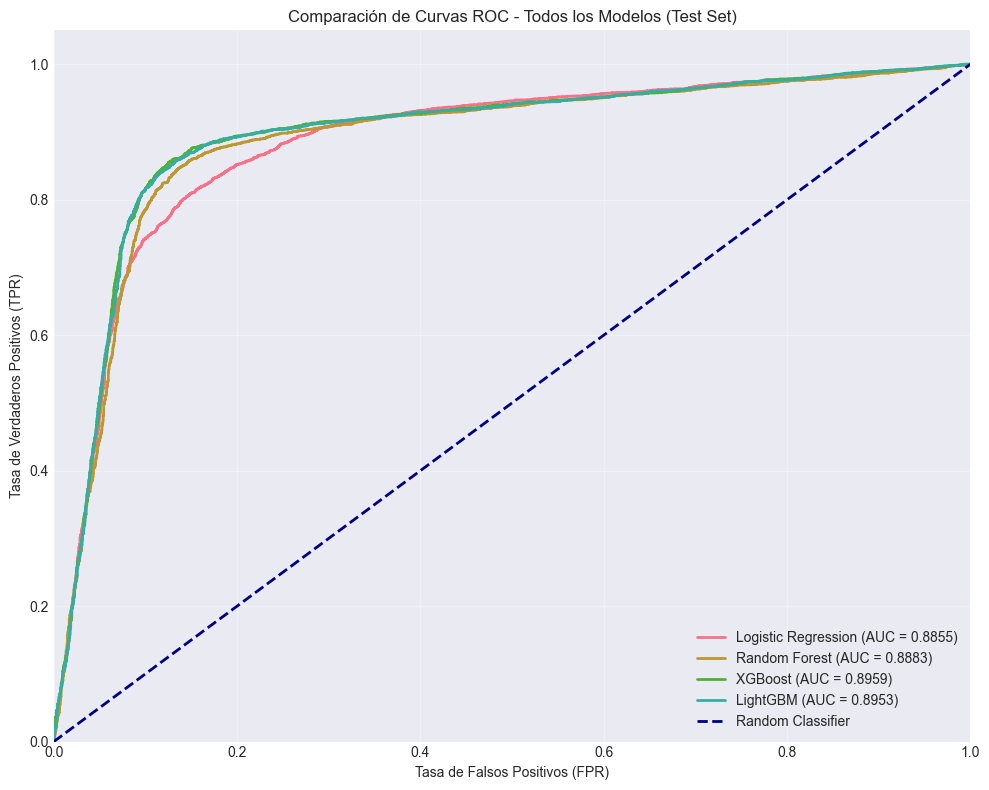

In [20]:
# Calcular curvas ROC para todos los modelos en test
plt.figure(figsize=(10, 8))

# Obtener predicciones de todos los modelos en test
models_predictions = {
    'Logistic Regression': best_model_lr.predict_proba(X_test)[:, 1],
    'Random Forest': best_model_rf.predict_proba(X_test)[:, 1],
    'XGBoost': best_model_xgb.predict_proba(X_test)[:, 1],
    'LightGBM': best_model_lgb.predict_proba(X_test)[:, 1]
}

for model_name, y_proba in models_predictions.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparación de Curvas ROC - Todos los Modelos (Test Set)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Resumen Final y Conclusiones


In [21]:
print("="*70)
print("📊 RESUMEN FINAL DEL MODELADO")
print("="*70)

print("\n1. MODELOS ENTRENADOS:")
print("   ✅ Logistic Regression")
print("   ✅ Random Forest")
print("   ✅ XGBoost")
print("   ✅ LightGBM")

print(f"\n2. MEJOR MODELO: {best_model_name}")
print(f"   ROC-AUC (Validation): {comparison_df.loc[best_model_name, 'roc_auc']:.4f}")
print(f"   ROC-AUC (Test):       {metrics_test['roc_auc']:.4f}")

print("\n3. MÉTRICAS EN TEST SET:")
for metric, value in metrics_test.items():
    print(f"   {metric:15s}: {value:.4f}")

print("\n4. MLFLOW:")
print(f"   ✅ Todos los modelos registrados en MLflow")
print(f"   ✅ Experimento: {EXPERIMENT_NAME}")
print(f"   🌐 UI: {MLFLOW_TRACKING_URI}")

print("\n5. PRÓXIMOS PASOS:")
print("   • Revisar resultados en MLflow UI")
print("   • Registrar el mejor modelo en Model Registry")
print("   • Preparar presentación con screenshots de MLflow")
print("   • Documentar insights y conclusiones")

print("\n" + "="*70)


📊 RESUMEN FINAL DEL MODELADO

1. MODELOS ENTRENADOS:
   ✅ Logistic Regression
   ✅ Random Forest
   ✅ XGBoost
   ✅ LightGBM

2. MEJOR MODELO: XGBoost
   ROC-AUC (Validation): 0.8879
   ROC-AUC (Test):       0.8959

3. MÉTRICAS EN TEST SET:
   accuracy       : 0.8642
   precision      : 0.8720
   recall         : 0.8526
   f1_score       : 0.8622
   roc_auc        : 0.8959
   log_loss       : 0.4242

4. MLFLOW:
   ✅ Todos los modelos registrados en MLflow
   ✅ Experimento: churn-prediction-experiment
   🌐 UI: http://localhost:5000

5. PRÓXIMOS PASOS:
   • Revisar resultados en MLflow UI
   • Registrar el mejor modelo en Model Registry
   • Preparar presentación con screenshots de MLflow
   • Documentar insights y conclusiones

